## Importing the relevant libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from tqdm.notebook import tqdm
tqdm.pandas()
import cv2, warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Add, Dropout, LSTM, TimeDistributed, Embedding, RepeatVector, Concatenate, Bidirectional, Convolution2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint

## Loading the images

In [2]:
img_path = '/kaggle/input/flickr8k/Images/'
images = glob(img_path+'*.jpg')
images[:5]

['/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg',
 '/kaggle/input/flickr8k/Images/214543992_ce6c0d9f9b.jpg',
 '/kaggle/input/flickr8k/Images/2366643786_9c9a830db8.jpg',
 '/kaggle/input/flickr8k/Images/3368819708_0bfa0808f8.jpg',
 '/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg']

In [3]:
len(images)

8091

## Loading the captions

In [4]:
captions = open('/kaggle/input/flickr8k/captions.txt','rb').read().decode('utf-8').split('\n')
captions[:5]

['image,caption',
 '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .']

## Visualizing images along with their captions

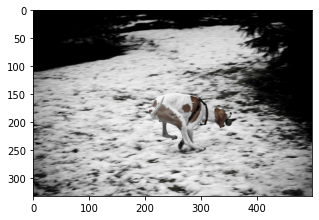

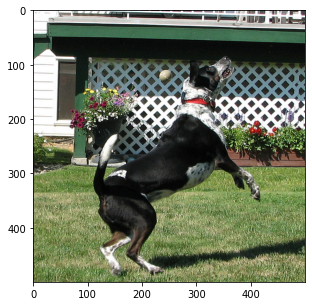

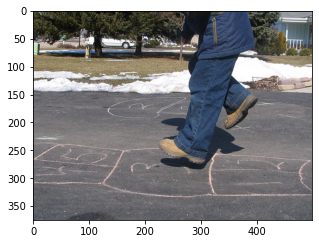

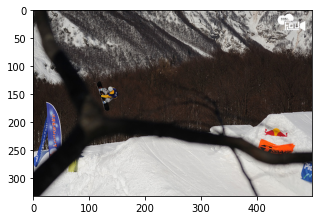

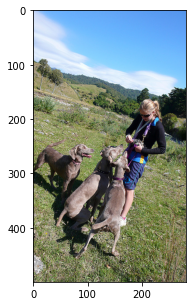

In [6]:
for i in range(5):
    plt.figure(figsize=(5,5))
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img);

## Downloading the ResNet50 inception model

In [7]:
inception_model = ResNet50(include_top=True)

102981632/102967424 [==============================] - 5s 0us/step


In [8]:
last = inception_model.layers[-2].output # Output of the penultimate layer of ResNet model 
model = Model(inputs=inception_model.input,outputs=last)

## Extracting features from images

In [9]:
img_features = {}
count = 0

for img_path in tqdm(images):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(224,224)) # ResNet model requires images of dimensions (224,224,3)
    img = img.reshape(1,224,224,3) # Reshaping image to the dimensions of a single image
    features = model.predict(img).reshape(2048,) # Feature extraction from images
    img_name = img_path.split('/')[-1] # Extracting image name
    img_features[img_name] = features
    count += 1
    # Fetching the features of only 1500 images as using more than 1500 images leads to overloading memory issues
    if count == 1500:
        break
    if count % 50 == 0:
        print(count)

  0%|          | 0/8091 [00:00<?, ?it/s]

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450


In [10]:
len(img_features)

1500

## Preprocessing the captions text

In [11]:
captions = captions[1:]
captions[:5]

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .']

In [13]:
captions_dict = {}

for cap in captions:
    try:
        img_name = cap.split(',')[0]
        caption = cap.split(',')[1]
        # Each image has 5 captions
        if img_name in img_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption] # Storing the first caption
            else:
                captions_dict[img_name].append(caption) # Adding the remaining captions 
    except:
        break

In [15]:
def text_preprocess(text):
    modified_text = text.lower() # Converting text to lowercase
    modified_text = 'startofseq ' + modified_text + ' endofseq' # Appending the special tokens at the beginning and ending of text
    return modified_text

In [16]:
# Storing the preprocessed text within the captions dictionary
for key, val in captions_dict.items():
    for item in val:
        captions_dict[key][val.index(item)] = text_preprocess(item)

## Creating vocabulary of the entire text corpus

In [17]:
count_words = dict()
cnt = 1

for key, val in captions_dict.items(): # Iterating through all images with keys as images and their values as 5 captions
    for item in val: # Iterating through all captions for each image
        for word in item.split(): # Iterating through all words in each caption
            if word not in count_words:
                count_words[word] = cnt
                cnt += 1

In [19]:
# Encoding the text by assigning each word to its corresponding index in the vocabulary i.e. count_words dictionary
for key, val in captions_dict.items():
    for caption in val:
        encoded = []
        for word in caption.split():
            encoded.append(count_words[word])
        captions_dict[key][val.index(caption)] = encoded

In [20]:
# Determining the maximum possible length of text within the entire captions text corpus
max_len = -1

for key, value in captions_dict.items():
    for caption in value:
        if max_len < len(caption):
            max_len = len(caption)

In [22]:
vocab_size = len(count_words) # Vocab size is the total number of words present in count_words dictionary
vocab_size

4031

## Building a custom generator function to generate input image features, previously generated text and the text to be generated as output

In [23]:
def generator(img,caption):
    n_samples = 0
    X = []
    y_input = []
    y_output = []
    
    for key, val in caption.items(): 
        for item in val: 
            for i in range(1,len(item)):
                X.append(img[key]) # Appending the input image features
                input_seq = [item[:i]] # Previously generated text to be used as input to predict the next word 
                output_seq = item[i] # The next word to be predicted as output
                # Padding encoded text sequences to the maximum length
                input_seq = pad_sequences(input_seq,maxlen=max_len,padding='post',truncating='post')[0] 
                # One Hot encoding the output sequence with vocabulary size as the total no. of classes
                output_seq = to_categorical([output_seq],num_classes=vocab_size+1)[0]
                y_input.append(input_seq)
                y_output.append(output_seq)
    
    return X, y_input, y_output

In [24]:
X, y_in, y_out = generator(img_features,captions_dict)

In [26]:
# Converting input and output into Numpy arrays for faster processing
X = np.array(X)
y_in = np.array(y_in,dtype='float64')
y_out = np.array(y_out,dtype='float64')

## Establishing the model architecture

In [39]:
embedding_len = 128
MAX_LEN = max_len
vocab_size = len(count_words)

# Model for image feature extraction
img_model = Sequential()
img_model.add(Dense(embedding_len,input_shape=(2048,),activation='relu'))
img_model.add(RepeatVector(MAX_LEN))

# Model for generating captions from image features
captions_model = Sequential()
captions_model.add(Embedding(input_dim=vocab_size+1,output_dim=embedding_len,input_length=MAX_LEN))
captions_model.add(LSTM(256,return_sequences=True))
captions_model.add(TimeDistributed(Dense(embedding_len)))

# Concatenating the outputs of image and caption models
concat_output = Concatenate()([img_model.output,captions_model.output])
# First LSTM Layer
output = LSTM(units=128,return_sequences=True)(concat_output)
# Second LSTM Layer
output = LSTM(units=512,return_sequences=False)(output)
# Output Layer 
output = Dense(units=vocab_size+1,activation='softmax')(output)
# Creating the final model
final_model = Model(inputs=[img_model.input,captions_model.input],outputs=output)
final_model.compile(loss='categorical_crossentropy',optimizer='RMSprop',metrics='accuracy')

## Model training

In [31]:
mc = ModelCheckpoint('image_caption_generator.h5',monitor='accuracy',verbose=1,mode='max',save_best_only=True)

final_model.fit([X,y_in],
                y_out,
                batch_size=512,
                callbacks=mc,
                epochs=200)

Epoch 1/200
180/180 [==============================] - 15s 57ms/step - loss: 5.1279 - accuracy: 0.1603

Epoch 00001: accuracy improved from -inf to 0.16030, saving model to image_caption_generator.h5
Epoch 2/200
180/180 [==============================] - 10s 57ms/step - loss: 4.5571 - accuracy: 0.2399

Epoch 00002: accuracy improved from 0.16030 to 0.23989, saving model to image_caption_generator.h5
Epoch 3/200
180/180 [==============================] - 10s 57ms/step - loss: 4.3863 - accuracy: 0.2555

Epoch 00003: accuracy improved from 0.23989 to 0.25547, saving model to image_caption_generator.h5
Epoch 4/200
180/180 [==============================] - 10s 57ms/step - loss: 4.2778 - accuracy: 0.2642

Epoch 00004: accuracy improved from 0.25547 to 0.26417, saving model to image_caption_generator.h5
Epoch 5/200
180/180 [==============================] - 10s 56ms/step - loss: 4.1726 - accuracy: 0.2761

Epoch 00005: accuracy improved from 0.26417 to 0.27607, saving model to image_caption_g

In [32]:
# Creating an inverse dictionary with reverse key-value pairs
inverse_dict = {val: key for key,val in count_words.items()}

## Generating sample predictions

In [35]:
# Custom function for extracting an image and transforming it into an appropriate format
def getImage(idx):
    test_img_path = images[idx]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img,(224,224))
    test_img = np.reshape(test_img,(1,224,224,3))
    return test_img

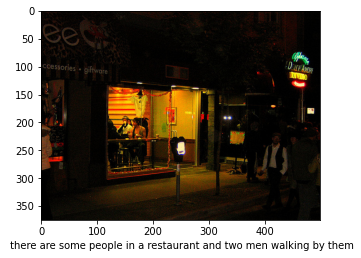

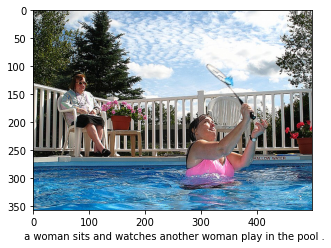

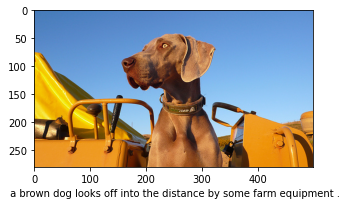

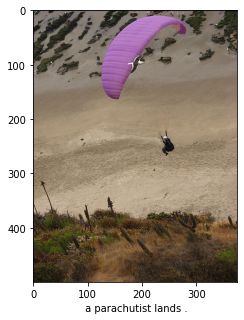

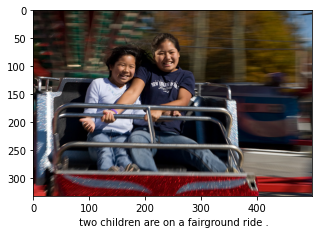

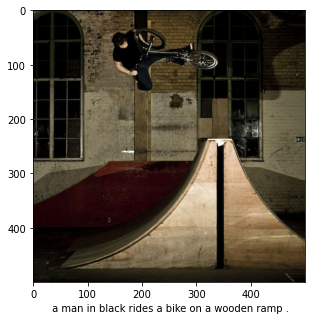

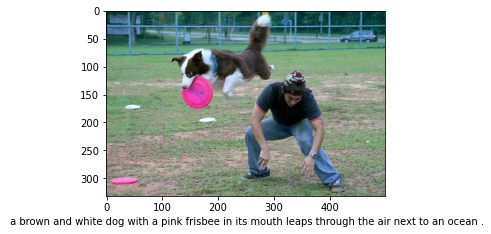

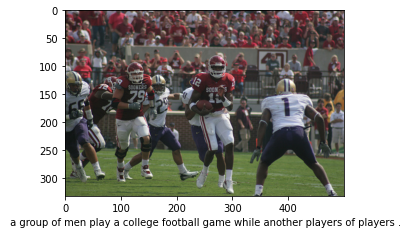

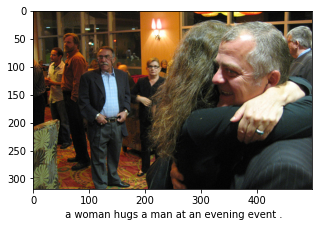

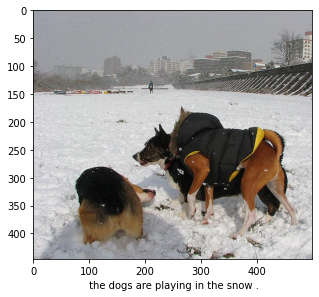

In [36]:
for i in range(10):
    random_no = np.random.randint(0,1501,(1,1))[0,0]
    test_feature = model.predict(getImage(random_no)).reshape(1,2048)
    test_img_path = images[random_no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    pred_text = ['startofseq']
    count = 0
    caption = '' # Stores the predicted captions text
    
    while count < 25:
        count += 1
        # Encoding the captions text with numbers
        encoded = []
        
        for i in pred_text:
            encoded.append(count_words[i])
        
        encoded = [encoded]
        # Padding the encoded text sequences to maximum length
        encoded = pad_sequences(encoded,maxlen=MAX_LEN,padding='post',truncating='post')
        pred_idx = np.argmax(final_model.predict([test_feature,encoded])) # Fetching the predicted word index having the maximum probability of occurrence
        sampled_word = inverse_dict[pred_idx] # Extracting the predicted word by its respective index
        # Checking for ending of the sequence
        if sampled_word == 'endofseq':
            break
        caption = caption + ' ' + sampled_word
        pred_text.append(sampled_word)
    
    plt.figure(figsize=(5,5))
    plt.imshow(test_img)
    plt.xlabel(caption)

Wow, simply astonishing! The image caption generation model has produced highly accurate predictions for all the above random images. <br>

So, this is it from my side. Kindly upvote my work if you absolutely loved it!